In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from psmiles import PolymerSmiles as PS
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt

random_seed = 123
torch.manual_seed(random_seed)
np.random.seed(random_seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_pickle("../../data/updated_polymers.pth")

In [4]:
scalar = MinMaxScaler()
data = df["fingerprint_miniLM"]
target = df["Egc"]

#data = data.values.reshape(-1, 1)  # Reshape data

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=123)

# Scaling target variable
target_train = scalar.fit_transform(target_train.values.reshape(-1, 1))
target_test = scalar.transform(target_test.values.reshape(-1, 1))

# Creating tensors from data

#Training Data
data_train_tensor = torch.tensor(data_train.reset_index(drop = True), dtype=torch.float32)
target_train_tensor = torch.tensor(target_train, dtype=torch.float32)

train_dataset = TensorDataset(data_train_tensor, target_train_tensor)
train_loader = DataLoader(train_dataset, batch_size= 32, shuffle= True)

#Testing Data

data_test_tensor = torch.tensor(data_test.reset_index(drop= True), dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

test_dataset = TensorDataset(data_test_tensor, target_test_tensor)
test_loader = DataLoader(test_dataset, shuffle= False)

In [5]:
class MTmodel(nn.Module):
    def __init__(self):
        super(MTmodel, self).__init__()
        self.my_layers = nn.ModuleList([
          nn.Sequential(
             nn.Linear(384, 1468),
                nn.Dropout(0.2609507424068107),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1468, 1632),
                nn.Dropout(0.12534946219186108),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1632, 1504),
                nn.Dropout(0.2403397127942421),
                nn.PReLU()
            ),
            nn.Linear(1504,1)
        ])
    
    def forward(self, x):
        for layer_step in self.my_layers:
            x = layer_step(x)
        return x

In [6]:
state_dict = torch.load("../../models/molecule_miniLM.pth")

In [7]:
net = MTmodel()

(net.my_layers[0][0].weight).values = state_dict['my_layers.0.0.weight']
(net.my_layers[0][0].bias).values = state_dict['my_layers.0.0.bias']
(net.my_layers[0][2].weight).values = state_dict['my_layers.0.2.weight']

for name, param in net.named_parameters():
        if '0.0' in name or '0.2' in name:
            param.requires_grad = False

net = net.to(DEVICE)
            
optimizer = optim.Adam(net.parameters(), lr =   0.000735976737127019)


EPOCHS = 471
losses = []
for epoch in range(EPOCHS):
  running_loss = 0.0
  correct = 0
  for batch_idx,(data, target) in enumerate(train_loader):

    data, target = data.to(DEVICE), target.view(-1).to(DEVICE)
    optimizer.zero_grad()
    output = net(data)
    loss = F.mse_loss(output.view(-1), target)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  epoch_loss = running_loss / batch_idx
  losses.append(epoch_loss)

  # Print epoch loss
  print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss}")

# Plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

[0.0200585769711151, 0.009967976313505676, 0.01001188499919538, 0.009174379816700128, 0.008772121315511564, 0.008857318482893919, 0.008891589443443254, 0.008571017921591798, 0.009332042012829334, 0.008805881695090128, 0.008121911458493699, 0.008495831557194748, 0.008062906976279226, 0.008420614143168288, 0.00814564365871428, 0.007765816754683675, 0.007890945089803566, 0.007730676199398225, 0.007029215838494045, 0.007462073560981523, 0.00736725997523449, 0.007431615332496308, 0.007070150134885418, 0.00668773428437167, 0.0067759005995910795, 0.006876006547827274, 0.00790817481798253, 0.006905514034553475, 0.007255845669923084, 0.0066722826172952495, 0.006434970421694396, 0.0064218052097463185, 0.006531371036544442, 0.006577533084921362, 0.006633278836185734, 0.006148562932919178, 0.006501963716887292, 0.006340465752319211, 0.006134097979936216, 0.006130123929497564, 0.006160538571531929, 0.006236332052919481, 0.005829854821231926, 0.0061024606416356705, 0.006126636107053075, 0.0056069556

mse: 0.4177034166557201, rmse: 0.6462997885313905, r2_score: 0.8002568680128179


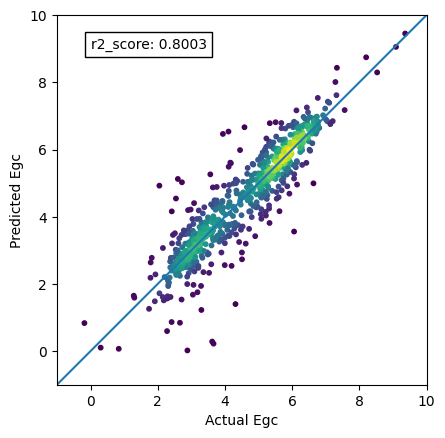

In [7]:
from scipy.stats import gaussian_kde

# Plot predictions vs. true values
@torch.no_grad()
def graphPredictions(model, data_loader , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    model = model.to(DEVICE)
    loss = []
    

    for (data,target) in (test_loader):
        # Single forward pass
        data, target =  data.to(DEVICE), target.to(DEVICE)
        pred = model(data)                              
        
        # Un-normalize our prediction
        pred = scalar.inverse_transform(pred.cpu().numpy())
        pred = torch.from_numpy(pred).to(DEVICE)
        target_cpu = scalar.inverse_transform(target.cpu().numpy())
        act = torch.from_numpy(target_cpu).to(DEVICE)
        loss = F.mse_loss(pred, act)

        # Save prediction and actual label
        predictions.append(tensor.cpu().item() for tensor in pred)
        actual.append(tensor.cpu().item() for tensor in act)


    pred_list = [item for sublist in predictions for item in sublist]
    act_list = [item for sublist in actual for item in sublist]

    
    mse = mean_squared_error(pred_list, act_list)
    rmse = mean_squared_error(pred_list, act_list, squared = False)
    r2 = r2_score(pred_list, act_list)
    print(f"mse: {mse}, rmse: {rmse}, r2_score: {r2}")

    # Calculate the point density
    xy = np.vstack([pred_list,act_list])
    z = gaussian_kde(xy)(xy)
    
    # Plot actuals vs predictions
    plt.scatter(pred_list, act_list, s= 10, c=z)
    plt.xlabel('Actual Egc')
    plt.ylabel('Predicted Egc')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    text_x = 0
    text_y = 9
    plt.text(text_x, text_y, f"r2_score: {round(r2, 4)}", fontsize=10, bbox=dict(facecolor='white', alpha=1))
    plt.show()


graphPredictions(net, test_loader, -1, 10)